# California Air Quality Index Forecasting

## Overview

In this project, I attempted to predict the air quality index for California with Recurrent Neural Network. I want to find out if there was any possible sudden increase in the AQI for the four gases after the COVID pandemic lockdown was lifted in 2020 as factories began their operations and day-to-day activities that involves carbon emissions resumes. The major difference that could have affected any sudden change in the AQI was the absence of the daily pollutants caused by day-to-day activities. After my analysis,

## Research Question

Will the trend of the AQIs increase significantly after the lockdown?

## Hypothesis

I believe all of the four quality index categories in California will increase significantly due to the resumption of production and day-to-day activities after the lockdown has been lifted.

## Importing Libraries

In [1]:
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Data Setup

In [2]:
data = pd.read_csv('pollution_2000_2021.csv')

In [3]:
data.shape

(608699, 24)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608699 entries, 0 to 608698
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               608699 non-null  object 
 1   Year               608699 non-null  int64  
 2   Month              608699 non-null  int64  
 3   Day                608699 non-null  int64  
 4   Address            608699 non-null  object 
 5   State              608699 non-null  object 
 6   County             608699 non-null  object 
 7   City               608699 non-null  object 
 8   O3 Mean            608699 non-null  float64
 9   O3 1st Max Value   608699 non-null  float64
 10  O3 1st Max Hour    608699 non-null  int64  
 11  O3 AQI             608699 non-null  int64  
 12  CO Mean            608699 non-null  float64
 13  CO 1st Max Value   608699 non-null  float64
 14  CO 1st Max Hour    608699 non-null  int64  
 15  CO AQI             608699 non-null  float64
 16  SO

In [5]:
data.describe()

,Year,Month,Day,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
count,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000,608699.000000
mean,2011.040529,6.508670,15.737176,0.028477,0.038903,10.773469,39.112517,0.337258,0.476798,5.971042,5.377387,1.523358,4.210271,8.851891,5.568708,11.738067,23.610711,11.606845,22.124240
std,6.122558,3.310633,8.806949,0.012218,0.015031,3.308152,22.480864,0.282958,0.446321,7.739380,5.142873,2.495094,7.983793,6.774720,10.736164,9.083091,15.412489,7.881014,14.610125
min,2000.000000,1.000000,1.000000,-0.000706,0.000000,7.000000,0.000000,-0.437500,-0.400000,0.000000,0.000000,-2.508333,-2.300000,0.000000,0.000000,-4.629167,-4.400000,0.000000,0.000000
25%,2006.000000,4.000000,8.000000,0.019647,0.029000,9.000000,27.000000,0.179167,0.200000,0.000000,2.000000,0.187500,0.600000,3.000000,0.000000,4.978261,11.200000,5.000000,10.000000
50%,2012.000000,7.000000,16.000000,0.028235,0.038000,10.000000,35.000000,0.262500,0.400000,2.000000,5.000000,0.666667,1.700000,8.000000,1.000000,9.541667,21.800000,9.000000,20.000000
75%,2016.000000,9.000000,23.000000,0.036765,0.048000,11.000000,44.000000,0.420833,0.600000,9.000000,7.000000,1.772727,4.000000,13.000000,6.000000,16.304348,33.700000,20.000000,31.000000
max,2021.000000,12.000000,31.000000,0.107353,0.140000,23.000000,237.000000,7.508333,15.500000,23.000000,201.000000,321.625000,351.000000,23.000000,200.000000,140.650000,269.200000,23.000000,133.000000


In [6]:
#Check for missing values
data.isnull().values.any()

False

In [7]:
data.head()

,Date,Year,Month,Day,Address,State,County,City,O3 Mean,O3 1st Max Value,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,2000-01-01,2000,1,1,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,2000-01-02,2000,1,2,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2000-01-03,2000,1,3,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,2000-01-04,2000,1,4,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,2000-01-05,2000,1,5,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58


## Data Preprocessing

In [8]:
data_df = data.drop(['Address'], axis = 1)
data_df.head()

,Date,Year,Month,Day,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,2000-01-01,2000,1,1,Arizona,Maricopa,Phoenix,0.019765,0.040,10,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,2000-01-02,2000,1,2,Arizona,Maricopa,Phoenix,0.015882,0.032,10,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2000-01-03,2000,1,3,Arizona,Maricopa,Phoenix,0.009353,0.016,9,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,2000-01-04,2000,1,4,Arizona,Maricopa,Phoenix,0.015882,0.033,9,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,2000-01-05,2000,1,5,Arizona,Maricopa,Phoenix,0.007353,0.012,9,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58


In [9]:
# California AQI
data_california = data_df[data_df['State'] == 'California']
data_california

,Date,Year,Month,Day,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
880,2000-01-01,2000,1,1,California,Contra Costa,Concord,0.019412,0.029,13,...,6,9.0,0.636364,2.0,9,3.0,14.782609,26.0,4,25
881,2000-01-02,2000,1,2,California,Contra Costa,Concord,0.017471,0.032,9,...,23,9.0,1.000000,2.0,5,3.0,16.043478,30.0,21,28
882,2000-01-03,2000,1,3,California,Contra Costa,Concord,0.006353,0.014,8,...,23,22.0,2.454545,4.0,13,6.0,25.521739,40.0,17,38
883,2000-01-04,2000,1,4,California,Contra Costa,Concord,0.008176,0.011,13,...,0,23.0,1.541667,4.0,17,6.0,26.041667,44.0,17,42
884,2000-01-05,2000,1,5,California,Contra Costa,Concord,0.012412,0.022,8,...,23,19.0,1.681818,4.0,10,6.0,23.772727,38.0,17,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594983,2021-09-26,2021,9,26,California,Solano,Vallejo,0.031353,0.037,7,...,0,2.0,0.859091,1.0,10,1.0,1.108696,2.6,15,2
594984,2021-09-27,2021,9,27,California,Solano,Vallejo,0.022353,0.029,20,...,0,2.0,0.836364,1.0,10,1.0,1.508696,3.7,17,3
594985,2021-09-28,2021,9,28,California,Solano,Vallejo,0.029647,0.036,9,...,0,2.0,0.927273,1.0,8,1.0,3.117391,11.8,6,10
594986,2021-09-29,2021,9,29,California,Solano,Vallejo,0.022941,0.033,11,...,0,2.0,1.031818,1.2,13,1.0,5.104348,15.6,22,14


In [10]:
# Setup all four AQIs for state and date
data_california = data_california[['Date', 'State', 'O3 AQI', 'CO AQI', 'SO2 AQI', 'NO2 AQI']]
data_california['Date'] = pd.to_datetime(data_california['Date'], format = '%Y-%m-%d')
data_california

C:\Users\blahb\AppData\Local\Temp/ipykernel_14448/1062832981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_california['Date'] = pd.to_datetime(data_california['Date'], format = '%Y-%m-%d')


,Date,State,O3 AQI,CO AQI,SO2 AQI,NO2 AQI
880,2000-01-01,California,27,9.0,3.0,25
881,2000-01-02,California,30,9.0,3.0,28
882,2000-01-03,California,13,22.0,6.0,38
883,2000-01-04,California,10,23.0,6.0,42
884,2000-01-05,California,20,19.0,6.0,36
...,...,...,...,...,...,...
594983,2021-09-26,California,34,2.0,1.0,2
594984,2021-09-27,California,27,2.0,1.0,3
594985,2021-09-28,California,33,2.0,1.0,10
594986,2021-09-29,California,31,2.0,1.0,14


## Cleaning Outliers

<AxesSubplot:xlabel='O3 AQI', ylabel='Density'>

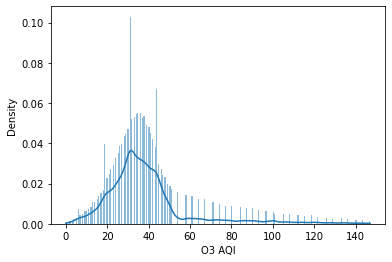

In [11]:
q1 = data_california['O3 AQI'].quantile(0.99)
O3_outliers = data_california[data_california['O3 AQI'] > q1]
data_california = data_california.drop(O3_outliers.index, axis= 0)
sns.histplot(data_california['O3 AQI'], kde=True, stat="density", linewidth=0)

<AxesSubplot:xlabel='CO AQI', ylabel='Density'>

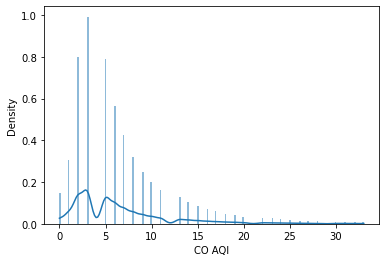

In [12]:
q2 = data_california['CO AQI'].quantile(0.99)
CO_outliers = data_california[data_california['CO AQI'] > q2]
data_california = data_california.drop(CO_outliers.index, axis= 0)
sns.histplot(data_california['CO AQI'], kde=True, stat="density", linewidth=0)

<AxesSubplot:xlabel='SO2 AQI', ylabel='Density'>

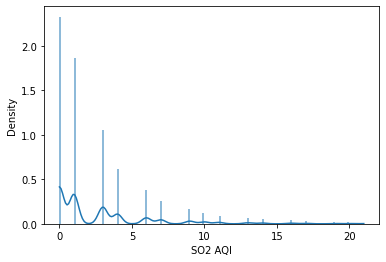

In [13]:
q3 = data_california['SO2 AQI'].quantile(0.99)
SO2_outliers = data_california[data_california['SO2 AQI'] > q3]
data_california = data_california.drop(SO2_outliers.index, axis= 0)
sns.histplot(data_california['SO2 AQI'], kde=True, stat="density", linewidth=0)

<AxesSubplot:xlabel='NO2 AQI', ylabel='Density'>

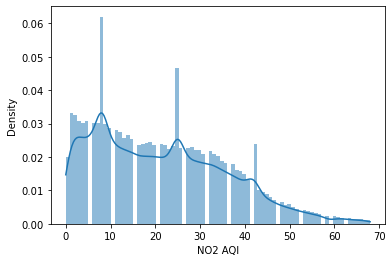

In [14]:
q4 = data_california['NO2 AQI'].quantile(0.99)
NO2_outliers = data_california[data_california['NO2 AQI'] > q4]
data_california = data_california.drop(NO2_outliers.index, axis= 0)
sns.histplot(data_california['NO2 AQI'], kde=True, stat="density", linewidth=0)

## Averaging the same dates

In [15]:
data_cali = data_california.groupby(['State', 'Date']).mean()
data_cali.rename(columns = {'O3 AQI':'Average O3 AQI', 'SO2 AQI': 'Average SO2 AQI', 'CO AQI': 'Average CO AQI', 'NO2 AQI':'Average NO2 AQI'}, inplace = True)
data_cali = data_cali.reset_index(level = [0,1])
data_cali

,State,Date,Average O3 AQI,Average CO AQI,Average SO2 AQI,Average NO2 AQI
0,California,2000-01-01,28.368421,9.526316,4.736842,22.105263
1,California,2000-01-02,31.750000,8.750000,3.900000,24.300000
2,California,2000-01-03,19.900000,18.150000,6.150000,36.350000
3,California,2000-01-04,19.823529,16.058824,6.352941,35.176471
4,California,2000-01-05,27.187500,13.312500,4.437500,28.500000
...,...,...,...,...,...,...
7939,California,2021-09-26,34.666667,2.833333,1.166667,3.166667
7940,California,2021-09-27,31.166667,3.000000,0.333333,6.333333
7941,California,2021-09-28,32.833333,2.666667,0.333333,11.000000
7942,California,2021-09-29,27.833333,3.666667,0.833333,16.500000


In [16]:
data_cali.info

<bound method DataFrame.info of            State       Date  Average O3 AQI  Average CO AQI  Average SO2 AQI  \
0     California 2000-01-01       28.368421        9.526316         4.736842   
1     California 2000-01-02       31.750000        8.750000         3.900000   
2     California 2000-01-03       19.900000       18.150000         6.150000   
3     California 2000-01-04       19.823529       16.058824         6.352941   
4     California 2000-01-05       27.187500       13.312500         4.437500   
...          ...        ...             ...             ...              ...   
7939  California 2021-09-26       34.666667        2.833333         1.166667   
7940  California 2021-09-27       31.166667        3.000000         0.333333   
7941  California 2021-09-28       32.833333        2.666667         0.333333   
7942  California 2021-09-29       27.833333        3.666667         0.833333   
7943  California 2021-09-30       41.166667        6.666667         1.166667   

      A

In [17]:
data_cali.tail(5)

,State,Date,Average O3 AQI,Average CO AQI,Average SO2 AQI,Average NO2 AQI
7939,California,2021-09-26,34.666667,2.833333,1.166667,3.166667
7940,California,2021-09-27,31.166667,3.000000,0.333333,6.333333
7941,California,2021-09-28,32.833333,2.666667,0.333333,11.000000
7942,California,2021-09-29,27.833333,3.666667,0.833333,16.500000
7943,California,2021-09-30,41.166667,6.666667,1.166667,21.000000


In [18]:
data_cali.head(15)

,State,Date,Average O3 AQI,Average CO AQI,Average SO2 AQI,Average NO2 AQI
0,California,2000-01-01,28.368421,9.526316,4.736842,22.105263
1,California,2000-01-02,31.750000,8.750000,3.900000,24.300000
2,California,2000-01-03,19.900000,18.150000,6.150000,36.350000
3,California,2000-01-04,19.823529,16.058824,6.352941,35.176471
4,California,2000-01-05,27.187500,13.312500,4.437500,28.500000
5,California,2000-01-06,21.333333,15.666667,6.500000,35.388889
6,California,2000-01-07,20.933333,15.333333,7.333333,34.266667
7,California,2000-01-08,19.882353,15.647059,5.705882,30.470588
8,California,2000-01-09,25.357143,11.428571,3.714286,24.857143
9,California,2000-01-10,21.937500,10.250000,3.250000,25.437500


## Monthly Data

In [19]:
# Monthly Data Average
monthly_data_cali = data_cali.groupby('State').resample('1M', label = 'right', closed = 'right', on = 'Date').mean().reset_index().sort_values(by = 'Date')
monthly_data_cali

,State,Date,Average O3 AQI,Average CO AQI,Average SO2 AQI,Average NO2 AQI
0,California,2000-01-31,20.799990,13.136601,4.907754,28.927184
1,California,2000-02-29,29.432550,10.523901,3.998811,28.017219
2,California,2000-03-31,38.187217,9.145068,5.038055,28.661404
3,California,2000-04-30,43.450170,7.730233,4.955956,25.670958
4,California,2000-05-31,45.868926,6.358298,5.276247,23.110310
...,...,...,...,...,...,...
256,California,2021-05-31,45.725497,2.694417,0.396845,11.362520
257,California,2021-06-30,43.471059,2.889608,0.422865,12.567462
258,California,2021-07-31,27.612903,2.143433,0.623848,4.930876
259,California,2021-08-31,36.094624,4.202151,0.688172,7.369892


### Data Visualization

<AxesSubplot:>

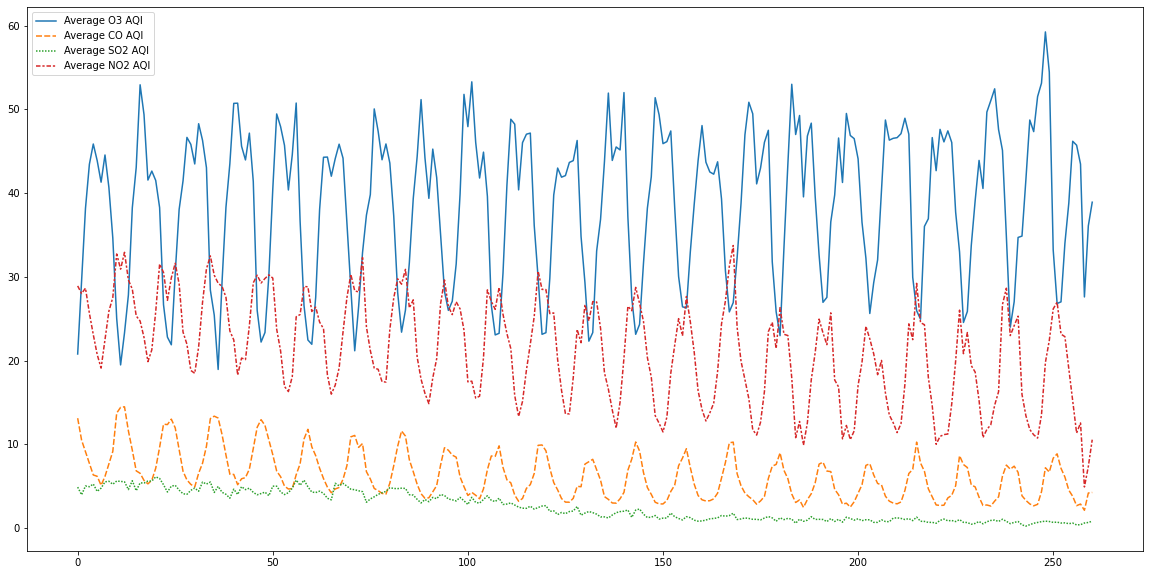

In [20]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = monthly_data_cali)

The chart represent the relatively wide-spread records of NO2 and O3. The graph shows that their monthly means lie between 20-30 parts per billion and 20-50 parts per million, respectively.

In [21]:
monthly_data_cali.shape

(261, 6)

## Time Series Model

### Hyperparameters


In [22]:
n_epochs = 2000                   
batch_size = 1                    # There is only 1 time series data. No other choice but 1. 
learn_rate = 0.0001
n_input = 1                       # Scalar input.
n_neurons = 100                   # N# of neurons per layer.
n_output = 1                      # Scalar output.
n_ts_seed = 20                    # Seed length.
n_predict_time_steps = 300
rmse = []

###  Exponential smoothing method and predict

#### O3

C:\Users\blahb\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


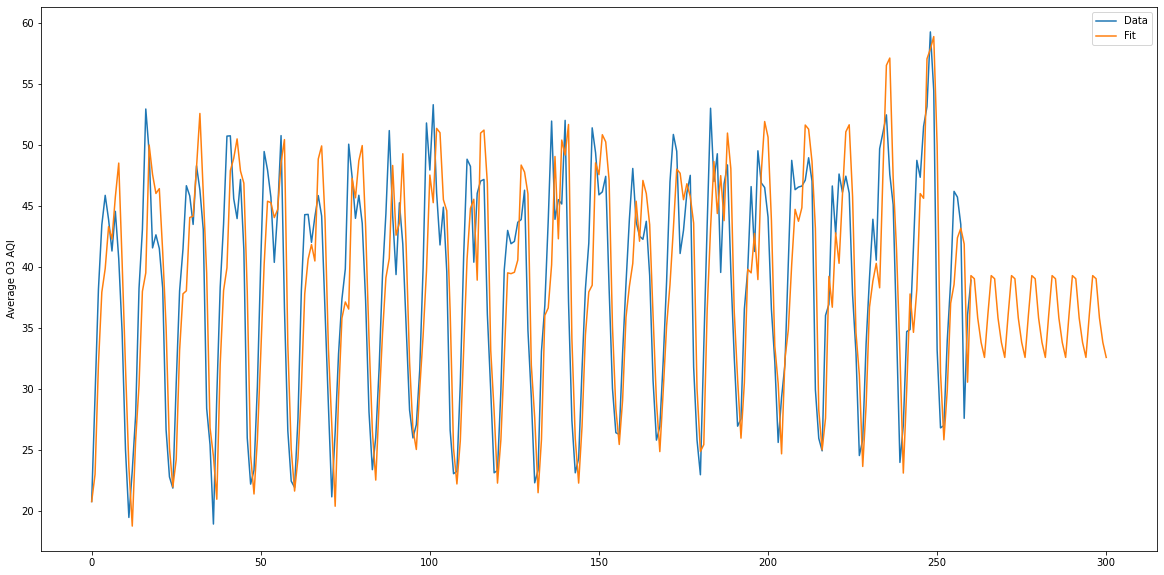

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
model = ExponentialSmoothing(monthly_data_cali['Average O3 AQI'][0:260], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start = 0, end = 300)
sns.lineplot(data = monthly_data_cali['Average O3 AQI'])
sns.lineplot(data = pred)
plt.legend(labels = ['Data', 'Fit'])
plt.show()

#### CO

C:\Users\blahb\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


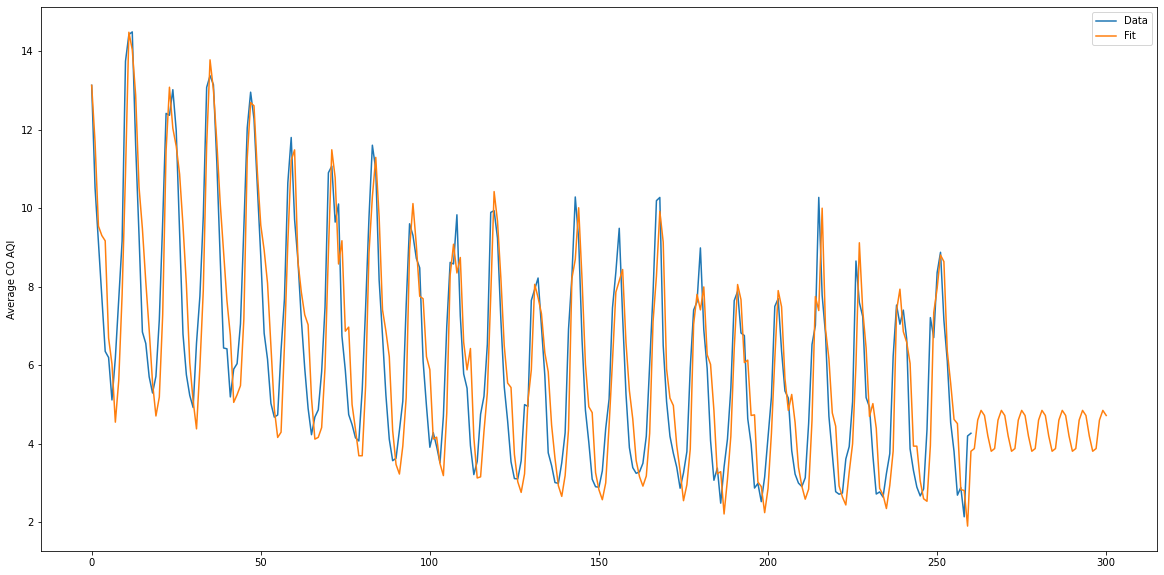

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
model = ExponentialSmoothing(monthly_data_cali['Average CO AQI'][0:260], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start = 0, end = 300)
sns.lineplot(data = monthly_data_cali['Average CO AQI'])
sns.lineplot(data = pred)
plt.legend(labels = ['Data', 'Fit'])
plt.show()

#### SO2

C:\Users\blahb\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


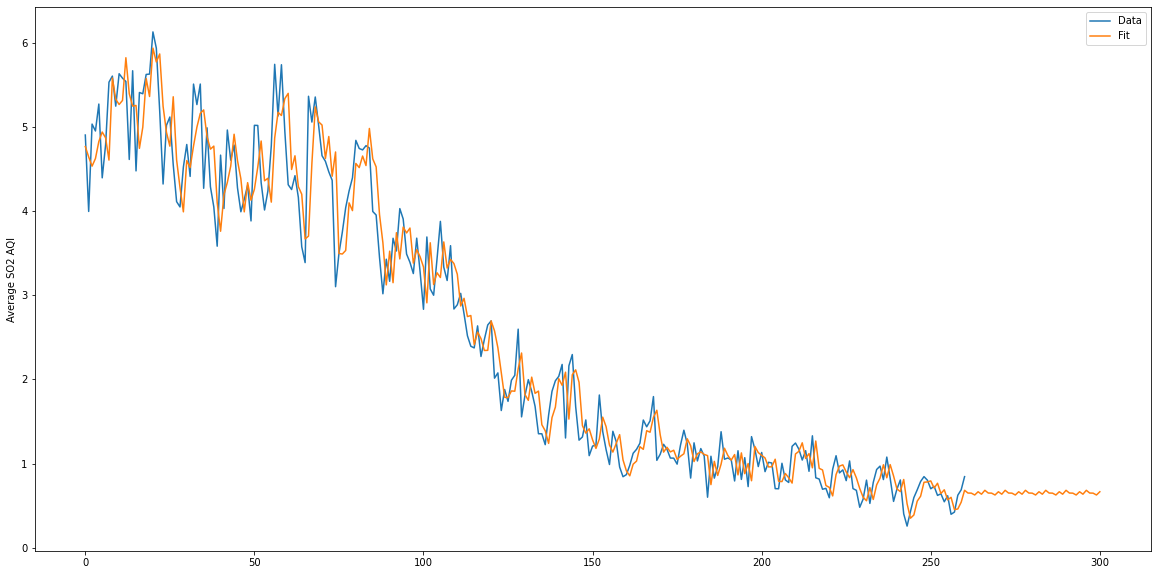

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
model = ExponentialSmoothing(monthly_data_cali['Average SO2 AQI'][0:260], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start = 0, end = 300)
sns.lineplot(data = monthly_data_cali['Average SO2 AQI'])
sns.lineplot(data = pred)
plt.legend(labels = ['Data', 'Fit'])
plt.show()

#### NO2

C:\Users\blahb\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


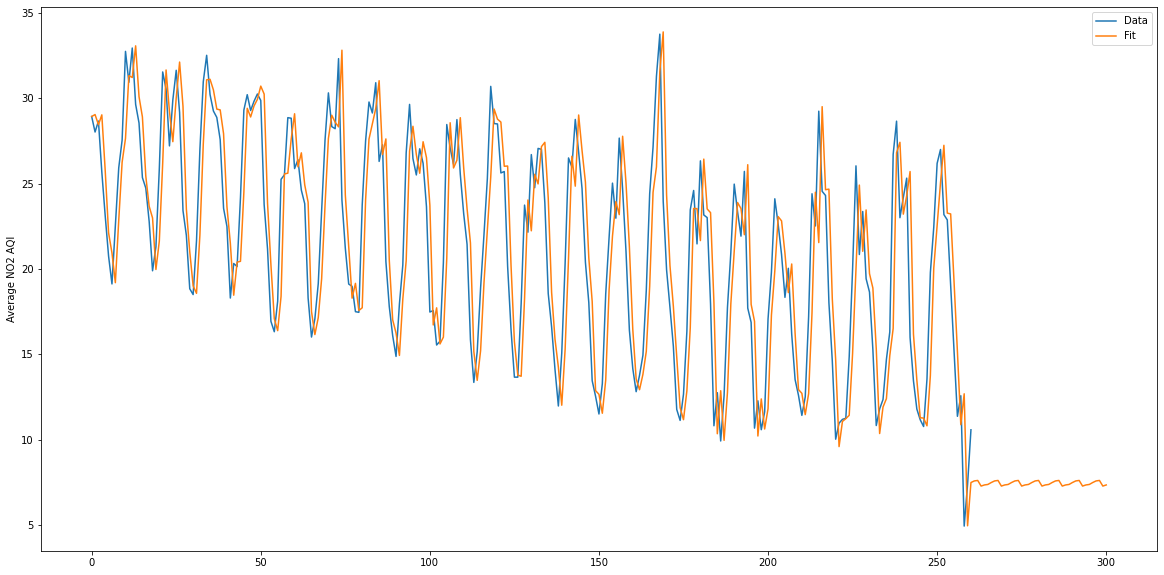

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
model = ExponentialSmoothing(monthly_data_cali['Average NO2 AQI'][0:260], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start = 0, end = 300)
sns.lineplot(data = monthly_data_cali['Average NO2 AQI'])
sns.lineplot(data = pred)
plt.legend(labels = ['Data', 'Fit'])
plt.show()

## Recurrent Neural Network (RNN)

### Preprocessing

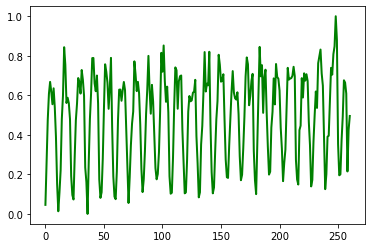

In [27]:
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(np.array(monthly_data_cali['Average O3 AQI']).reshape(-1,1))
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [28]:
ts_scaled_2 = ts_scaled.reshape(1,-1,1) #Reshaping

### Model

In [29]:
my_model_O3 = Sequential()
my_model_O3.add(SimpleRNN(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))     # RNN.
my_model_O3.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [30]:
my_model_O3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 100)         10200     
                                                                 
 time_distributed (TimeDistr  (None, None, 1)          101       
 ibuted)                                                         
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Define the optimizer and compile.
my_optimizer = Adam(learning_rate = learn_rate)
my_model_O3.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

### Train the model

In [32]:
# Separate the training history and combine the time series plots 
my_summary_O3 = my_model_O3.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [33]:
my_summary_O3.history.keys()

dict_keys(['loss', 'mse'])

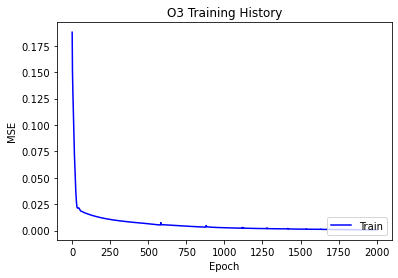

In [34]:
plt.plot(my_summary_O3.history['mse'], c="b")
plt.title('O3 Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

### Prediction

In [35]:
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model_O3.predict(X)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

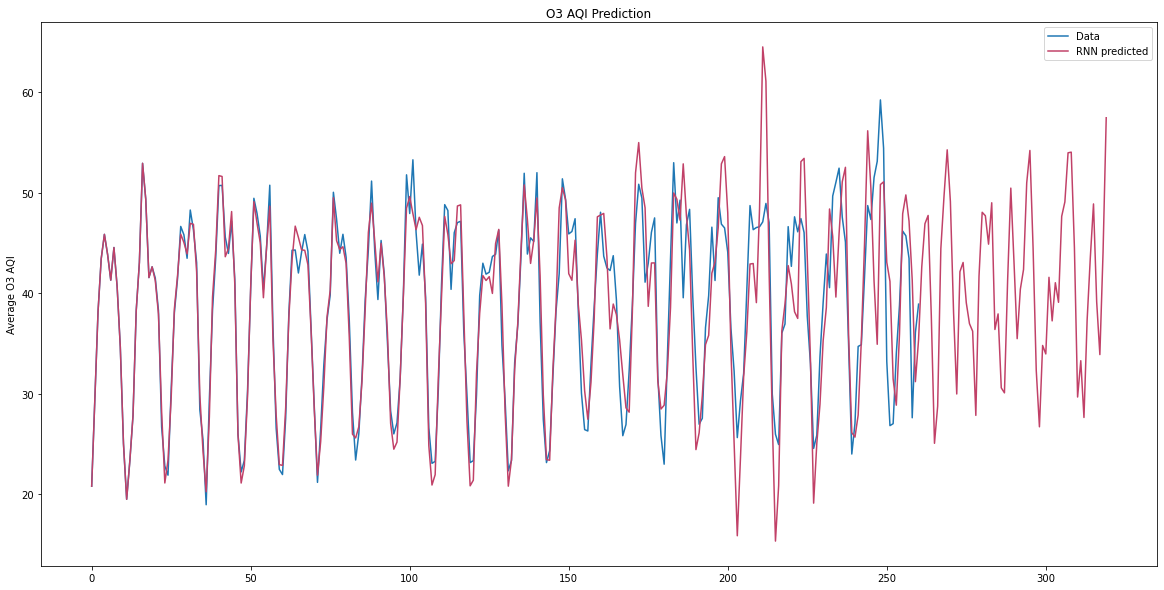

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
ts = scaler.inverse_transform(ts_seed)
ax = sns.lineplot(data = monthly_data_cali['Average O3 AQI'])
ax = sns.lineplot(data = ts, palette = 'flare')
ax.set_title("O3 AQI Prediction")
ax.legend(labels = ['Data', 'RNN predicted'])

The model somewhat captured the air quality index seasonality to an extent. However, the sudden increase in the predicted O3 AQI values in 2015 indicated a high error rate for the model, making the model relatively inaccurate.

In [37]:
mse_O3 = mean_squared_error(monthly_data_cali['Average O3 AQI'], ts[0:261])
rmse_O3 = sqrt(mse_O3)
print('The Root Mean Squared Error of O3 forecast is {}'.format(round(rmse_O3, 2)))
rmse.append(round(rmse_O3, 2))

The Root Mean Squared Error of O3 forecast is 4.04


## Repeat for CO, SO2, NO2 AQI

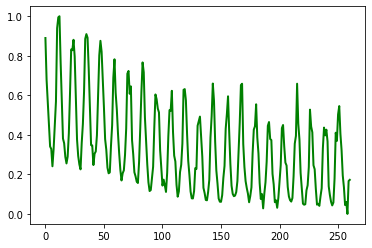

In [38]:
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(np.array(monthly_data_cali['Average CO AQI']).reshape(-1,1))
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [39]:
ts_scaled_2 = ts_scaled.reshape(1,-1,1)

In [40]:
my_model_CO = Sequential()
my_model_CO.add(SimpleRNN(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))     # RNN.
my_model_CO.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [41]:
my_model_CO.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 100)         10200     
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1)          101       
 tributed)                                                       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [42]:
my_model_CO.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

In [43]:
my_summary_CO = my_model_CO.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [44]:
my_summary_CO.history.keys()

dict_keys(['loss', 'mse'])

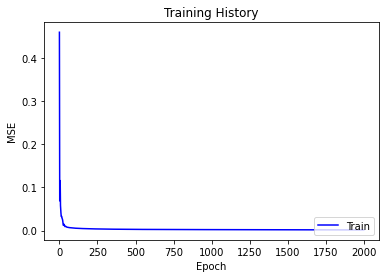

In [45]:
plt.plot(my_summary_CO.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [46]:
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model_CO.predict(X)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

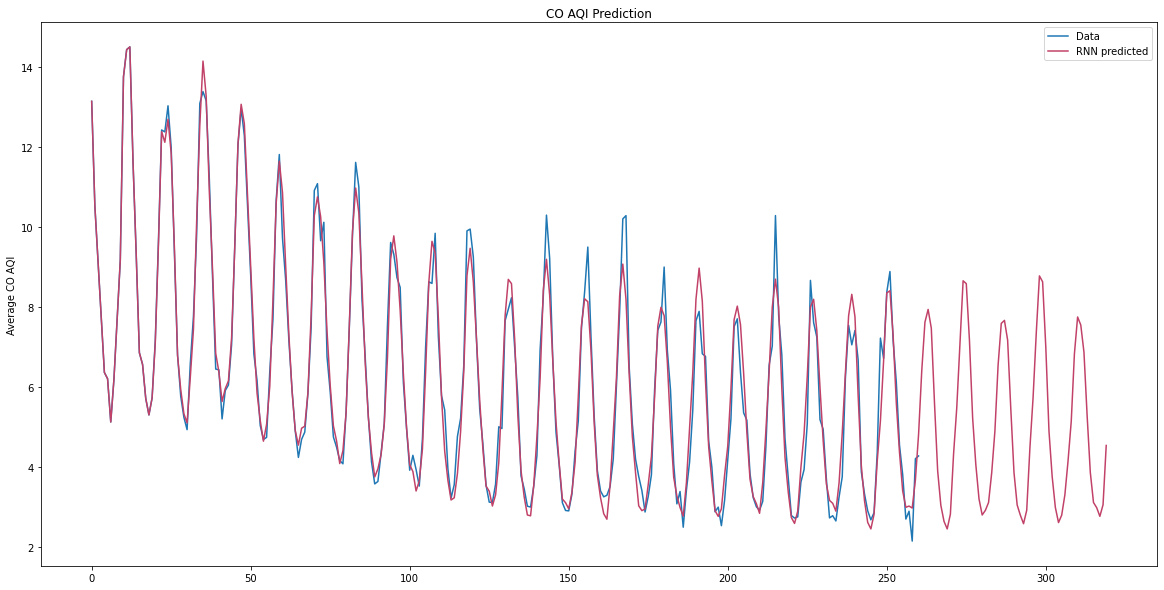

In [47]:
fig, ax = plt.subplots(figsize=(20,10))
ts = scaler.inverse_transform(ts_seed)
ax = sns.lineplot(data = monthly_data_cali['Average CO AQI'])
ax = sns.lineplot(data = ts, palette = 'flare')
ax.set_title("CO AQI Prediction")
ax.legend(labels = ['Data', 'RNN predicted'])

The model almost captured the air quality index seasonality, which make the predicted values quite accurate in comparison to the trend.

In [48]:
mse_CO = mean_squared_error(monthly_data_cali['Average CO AQI'], ts[0:261])
rmse_CO = sqrt(mse_CO)
print('The Root Mean Squared Error of CO forecast is {}'.format(round(rmse_CO, 2)))
rmse.append(round(rmse_CO, 2))

The Root Mean Squared Error of CO forecast is 0.5


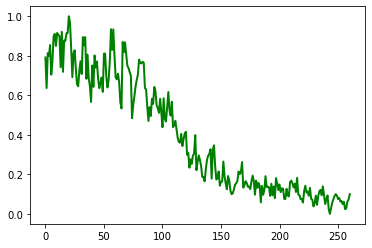

In [49]:
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(np.array(monthly_data_cali['Average SO2 AQI']).reshape(-1,1))
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [50]:
ts_scaled_2 = ts_scaled.reshape(1,-1,1)

In [51]:
my_model_SO2 = Sequential()
my_model_SO2.add(SimpleRNN(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))     # RNN.
my_model_SO2.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [52]:
my_model_SO2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 100)         10200     
                                                                 
 time_distributed_2 (TimeDis  (None, None, 1)          101       
 tributed)                                                       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [53]:
my_model_SO2.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

In [54]:
my_summary_SO2 = my_model_SO2.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [55]:
my_summary_SO2.history.keys()

dict_keys(['loss', 'mse'])

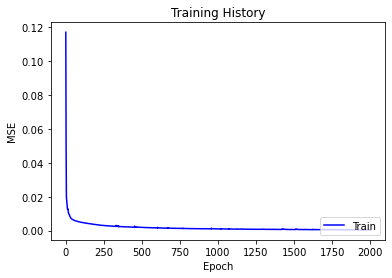

In [56]:
plt.plot(my_summary_SO2.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [57]:
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model_SO2.predict(X)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

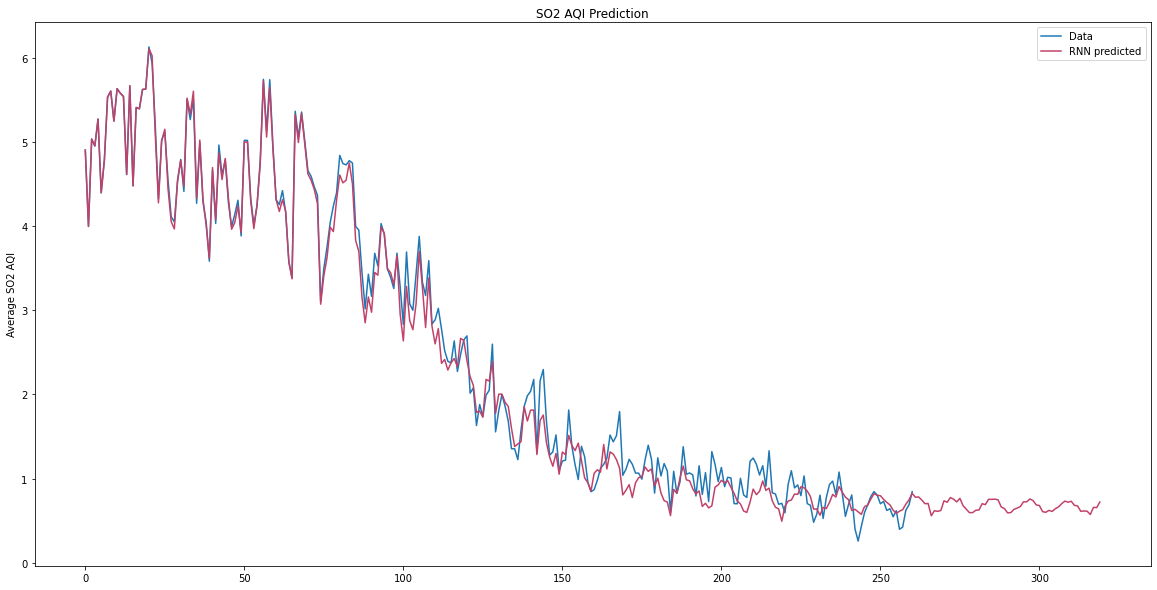

In [58]:
fig, ax = plt.subplots(figsize=(20,10))
ts = scaler.inverse_transform(ts_seed)
ax = sns.lineplot(data = monthly_data_cali['Average SO2 AQI'])
ax = sns.lineplot(data = ts, palette = 'flare')
ax.set_title("SO2 AQI Prediction")
ax.legend(labels = ['Data', 'RNN predicted'])

The model somewhat captured the air quality index seasonality to an extent. It seems that the model is unable to fully predict some of the observed data due to quick fluctating values. 

In [59]:
mse_SO2 = mean_squared_error(monthly_data_cali['Average SO2 AQI'], ts[0:261])
rmse_SO2 = sqrt(mse_SO2)
print('The Root Mean Squared Error of SO2 forecast is {}'.format(round(rmse_SO2, 2)))
rmse.append(round(rmse_SO2, 2))

The Root Mean Squared Error of SO2 forecast is 0.18


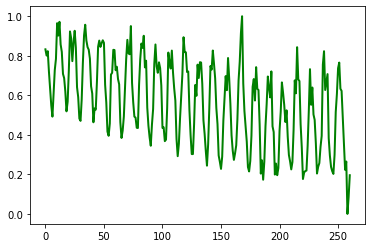

In [60]:
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(np.array(monthly_data_cali['Average NO2 AQI']).reshape(-1,1))
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [61]:
ts_scaled_2 = ts_scaled.reshape(1,-1,1)

In [62]:
my_model_NO2 = Sequential()
my_model_NO2.add(SimpleRNN(units=n_neurons, return_sequences=True, input_shape=(None, n_input)))     # RNN.
my_model_NO2.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

In [63]:
my_model_NO2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 100)         10200     
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1)          101       
 tributed)                                                       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [64]:
my_model_NO2.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

In [65]:
my_summary_NO2 = my_model_NO2.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [66]:
my_summary_NO2.history.keys()

dict_keys(['loss', 'mse'])

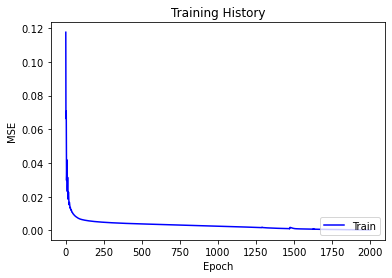

In [67]:
plt.plot(my_summary_NO2.history['mse'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

In [68]:
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model_NO2.predict(X)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

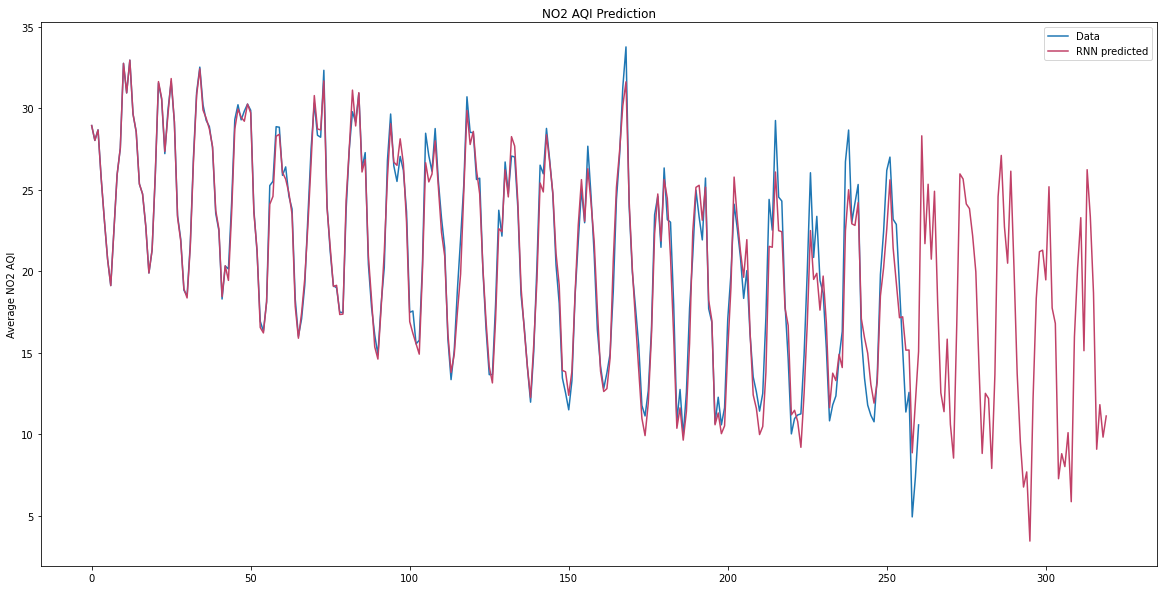

In [69]:
fig, ax = plt.subplots(figsize=(20,10))
ts = scaler.inverse_transform(ts_seed)
ax = sns.lineplot(data = monthly_data_cali['Average NO2 AQI'])
ax = sns.lineplot(data = ts, palette = 'flare')
ax.set_title("NO2 AQI Prediction")
ax.legend(labels = ['Data', 'RNN predicted'])

The model somewhat captured the air quality index seasonality to an extent, which make the predicted values slightly accurate in comparison to the trend.

In [70]:
mse_NO2 = mean_squared_error(monthly_data_cali['Average NO2 AQI'], ts[0:261])
rmse_NO2 = sqrt(mse_NO2)
print('The Root Mean Squared Error of NO2 forecast is {}'.format(round(rmse_NO2, 2)))
rmse.append(round(rmse_NO2, 2))

The Root Mean Squared Error of NO2 forecast is 1.26


### Error Analysis

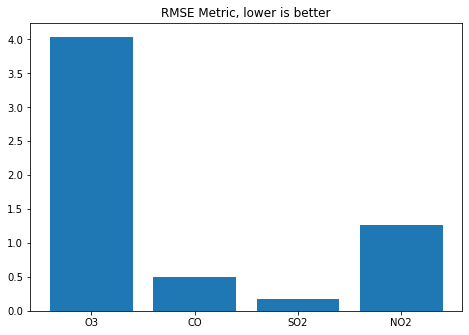

[4.04, 0.5, 0.18, 1.26]


In [71]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
AQIs = ['O3', 'CO', 'SO2', 'NO2']
ax.bar(AQIs, rmse)
plt.title('RMSE Metric, lower is better')
plt.show()
print(rmse)

The Root Mean Square Error(RMSE) for O3 is quite high, which is reflected by the the model not clearly capturing the seasonality of the AQI. Thus, it's fair to assume that the prediction for O3 is not accurate. The Root Mean Square Error(RMSE) for NO2 is somewhat high, meaning it's accurate to some extent. As for CO and SO2, the Root Mean Square Error(RMSE) is low, making the prediction relatively accurate.

- While observing the reoccuring seasonal patterns for all of the four air quality index categories for California, CO and SO2 maintain a declining trend while NO2 is showing no significant changes in the trend. O3 shows a slightly increasing trend, but the predicted values is not accurate.
- After my analysis, I reject the null hypothesis and therefore concluded that there was no significant increase in all of the four quality index categories in California due to the resumption of production and day-to-day activities after the lockdown has been lifted.